In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from surprise import SlopeOne
sns.set()

In [3]:
df = pd.read_csv('data/responses.csv')
df = df.fillna(df.mean())
df.shape

(1010, 150)

In [4]:
PHOBIAS_IDS = range(63,73)
PREFERENCES_IDS = list(range(63)) + [len(df.columns)-6] # + gender

In [5]:
preferences_cols = df.columns[PREFERENCES_IDS]
phobias_cols = df.columns[PHOBIAS_IDS]

In [6]:
df['Gender'] = (df['Gender'] == 'male').astype(np.float)

In [7]:
df[phobias_cols].head()

,Flying,Storm,Darkness,Heights,Spiders,Snakes,Rats,Ageing,Dangerous dogs,Fear of public speaking
0,1.0,1.0,1.0,1.0,1.0,5,3.0,1.0,3.0,2.0
1,1.0,1.0,1.0,2.0,1.0,1,1.0,3.0,1.0,4.0
2,1.0,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0,2.0
3,2.0,1.0,1.0,3.0,5.0,5,5.0,4.0,5.0,5.0
4,1.0,2.0,1.0,1.0,1.0,1,2.0,2.0,4.0,3.0


In [8]:
df_corr = pd.DataFrame(columns=phobias_cols)

In [9]:
for phobia in phobias_cols:
    df_corr[phobia]=df[preferences_cols].corrwith(df[phobia])

<AxesSubplot:>

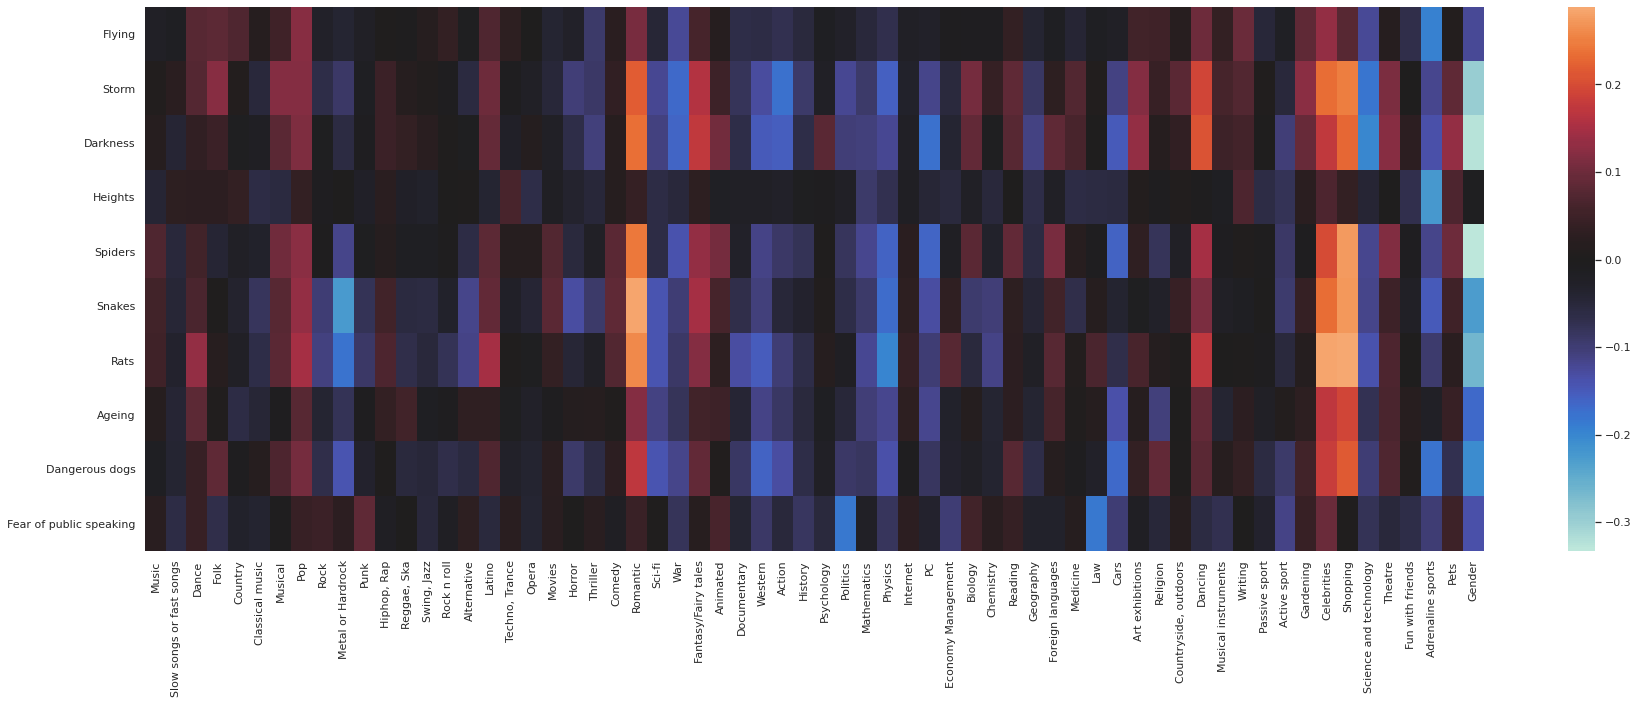

In [10]:
fig, ax = plt.subplots(figsize=(30,10))
sns.heatmap(df_corr.T, xticklabels=preferences_cols, yticklabels=phobias_cols, center=0, ax=ax)

# Predicting phobias knowing preferences

In [12]:
train_inds, test_inds = train_test_split(np.arange(len(df)), test_size=0.2, random_state=0)

train_df = df.loc[train_inds]
test_df = df.loc[test_inds]

In [13]:
def grid_search(target):
    estimators = [1,2,5,10,20,50,100]
    depths = [1,2,3,4,5,7,10,20,None]

    train_errors = np.empty((len(estimators), len(depths)))
    test_errors = np.empty((len(estimators), len(depths)))

    for e, n_estimators in enumerate(estimators):
        for d, max_depth in enumerate(depths):
            X_train, y_train = train_df[preferences_cols], train_df[target]
            X_test, y_test = test_df[preferences_cols], test_df[target]

            xg_reg = xgb.XGBRegressor(
                random_state=0,
                n_estimators = n_estimators,
                max_depth = max_depth,
            )

            xg_reg.fit(
                X_train,
                y_train,
            )

            train_errors[e, d] = mean_squared_error(y_train, xg_reg.predict(X_train))
            test_errors[e, d] = mean_squared_error(y_test, xg_reg.predict(X_test))

    n_estimators = estimators[test_errors.argmin() // len(depths)]
    max_depth = depths[test_errors.argmin() % len(depths)]

    fig, ax = plt.subplots(1, 2)
    sns.heatmap(train_errors, xticklabels=depths, yticklabels=estimators, cmap="YlGnBu", ax=ax[0])
    sns.heatmap(test_errors, xticklabels=depths, yticklabels=estimators, cmap="YlGnBu", ax=ax[1])
    fig.set_size_inches(25,10)
    fig.suptitle(f'Target: {target}, mean err: {mean_squared_error(y_test, np.full(len(y_test), y_train.mean())):.3f}, best err: {test_errors.min():.3f}, n_estimators={n_estimators}, max_depth={max_depth}')
    plt.show()

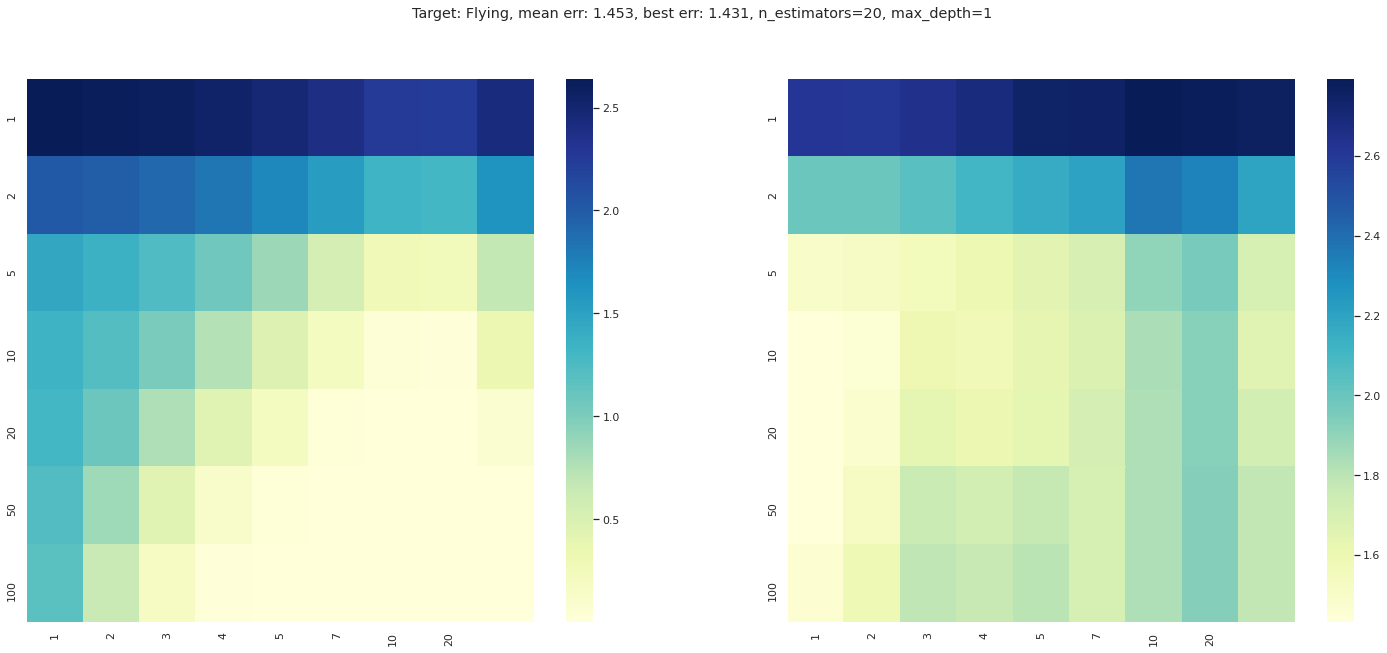

In [14]:
grid_search('Flying')

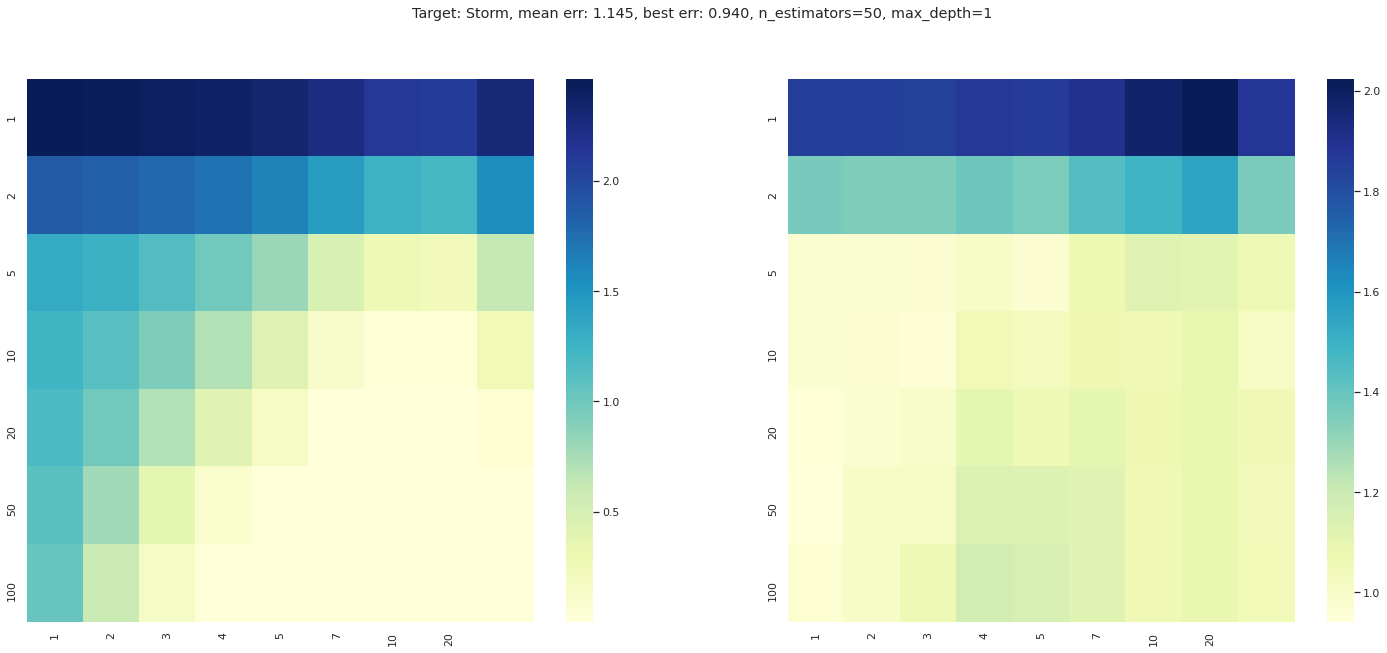

In [166]:
grid_search('Storm')

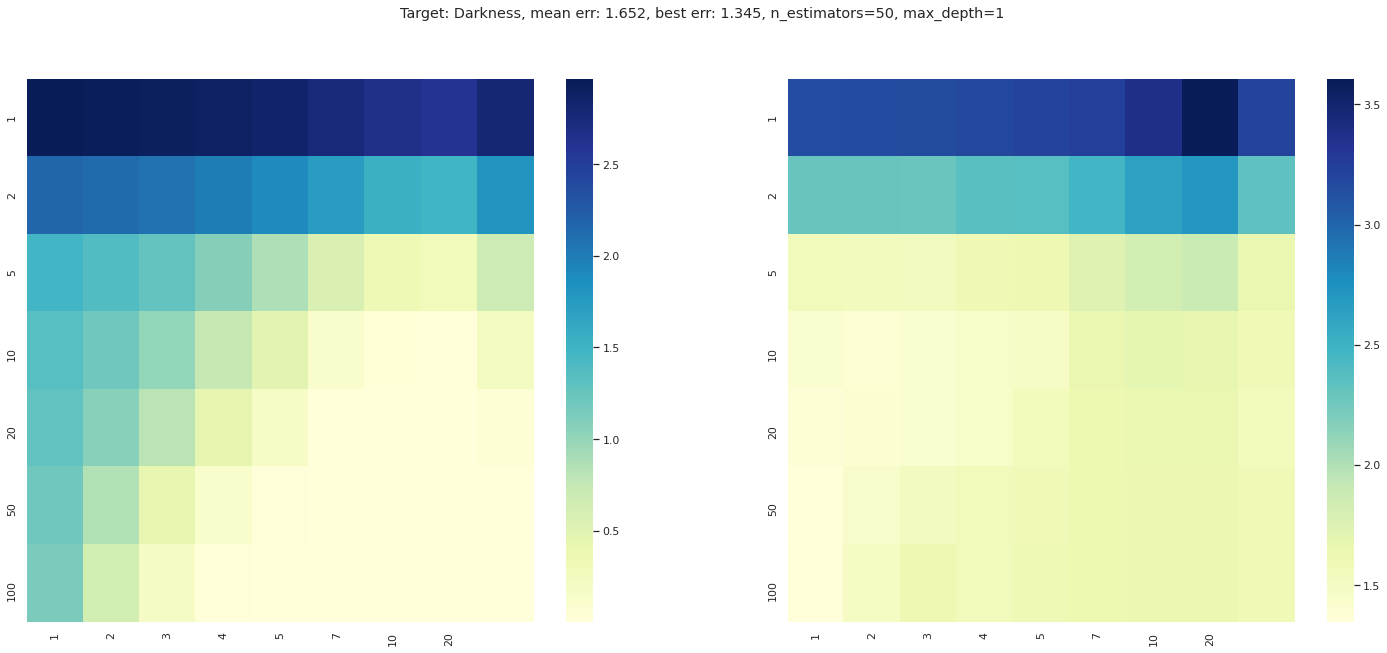

In [168]:
grid_search('Darkness')

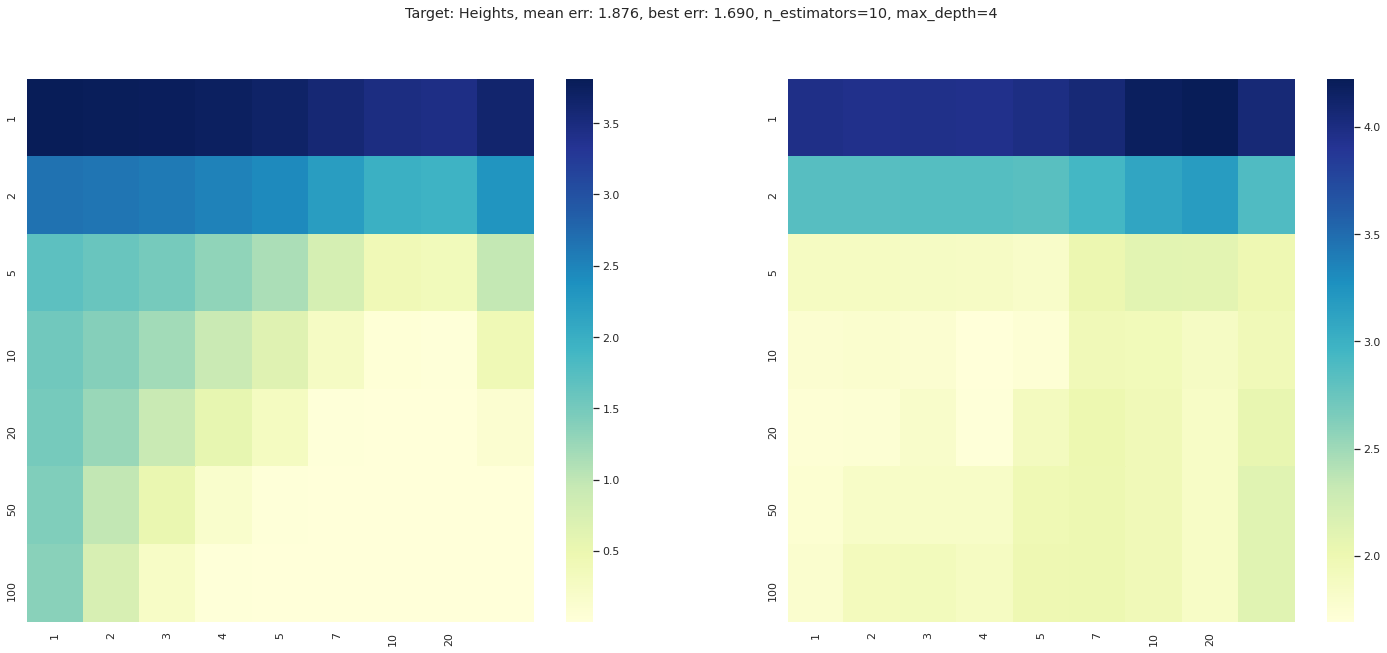

In [170]:
grid_search('Heights')

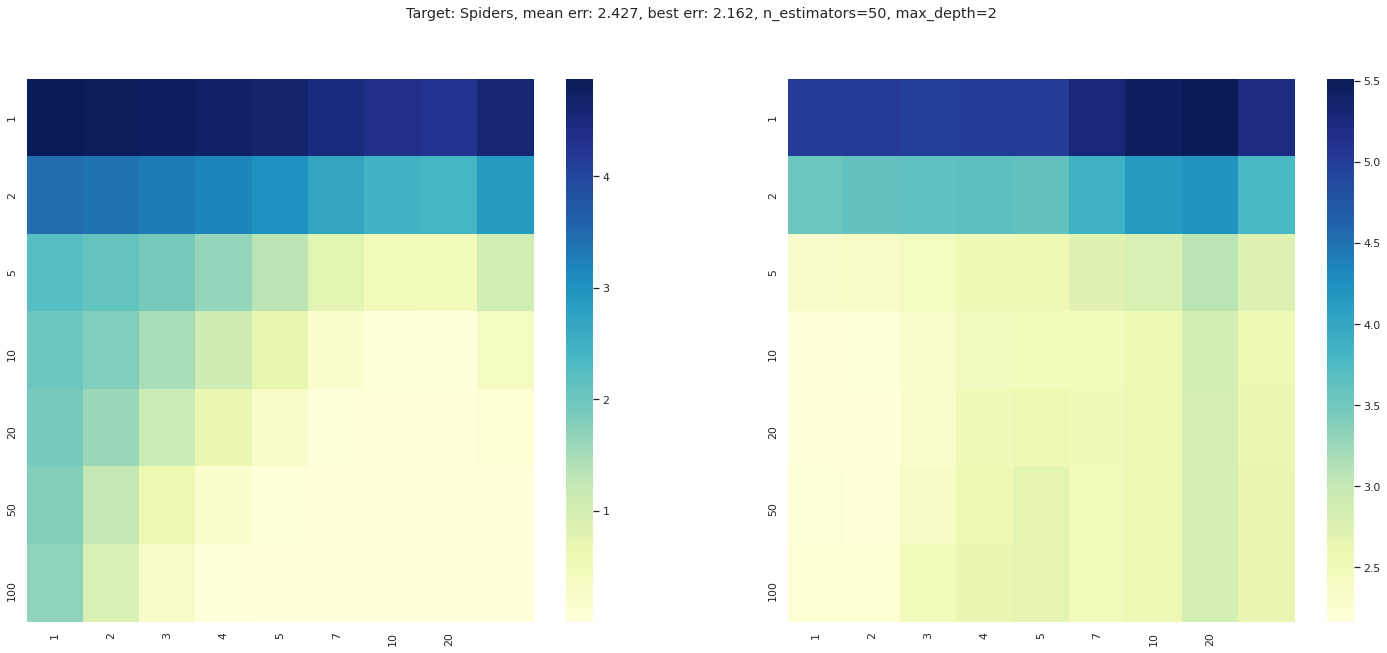

In [171]:
grid_search('Spiders')

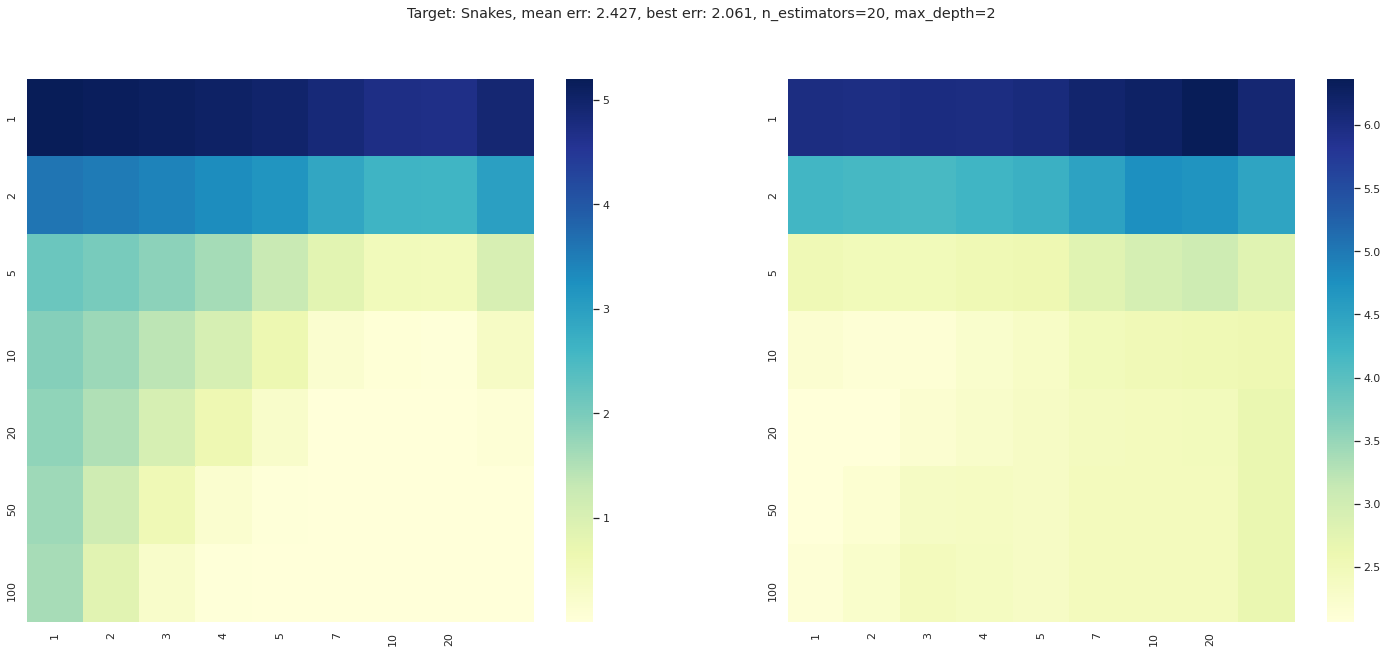

In [172]:
grid_search('Snakes')

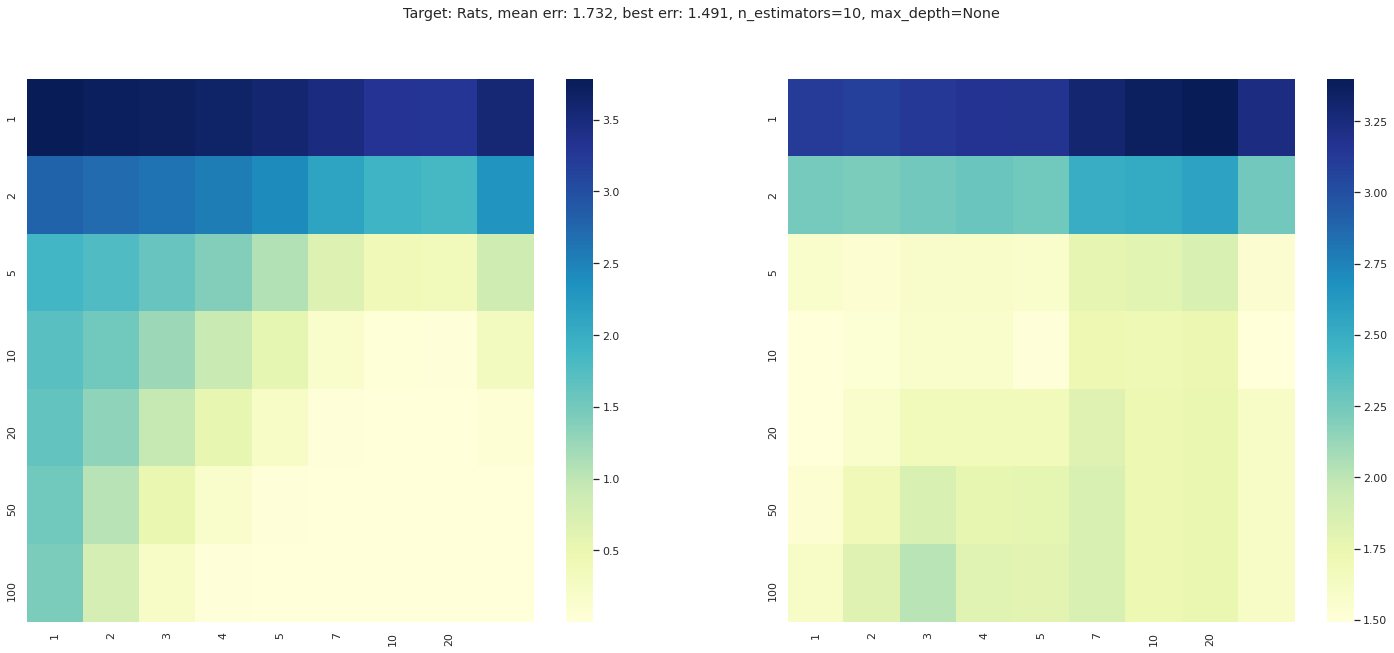

In [173]:
grid_search('Rats')

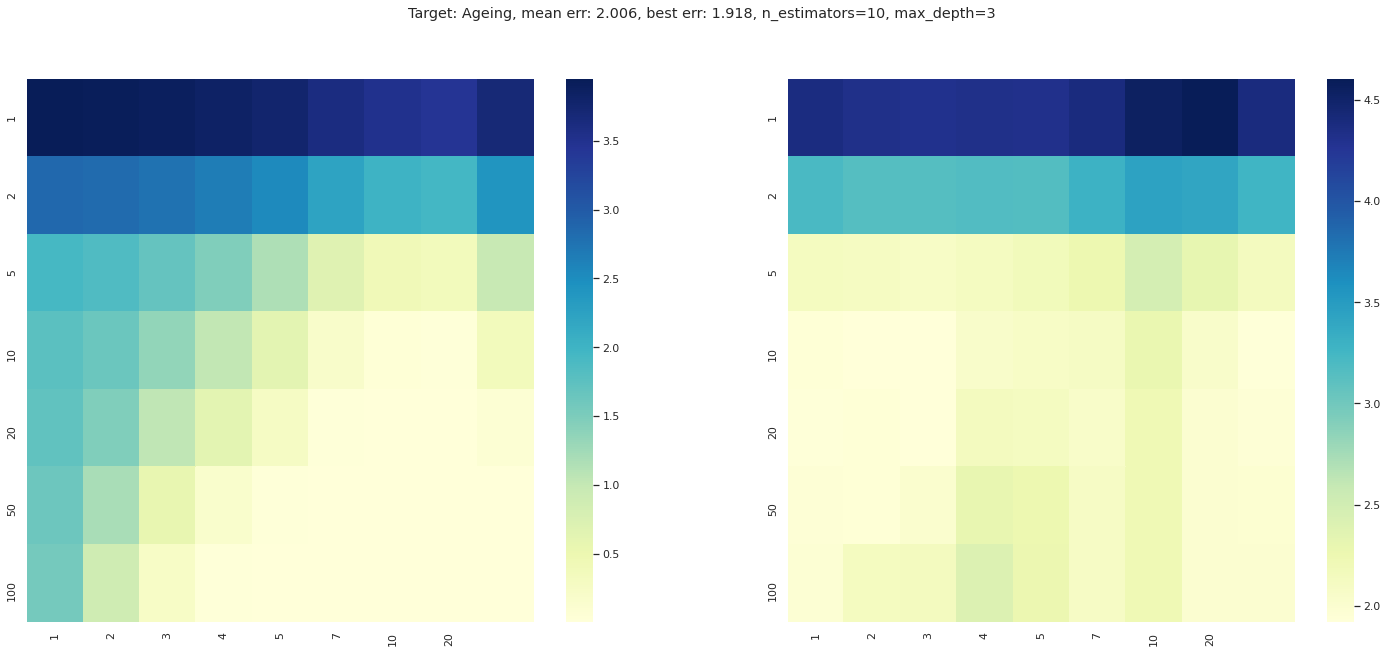

In [174]:
grid_search('Ageing')

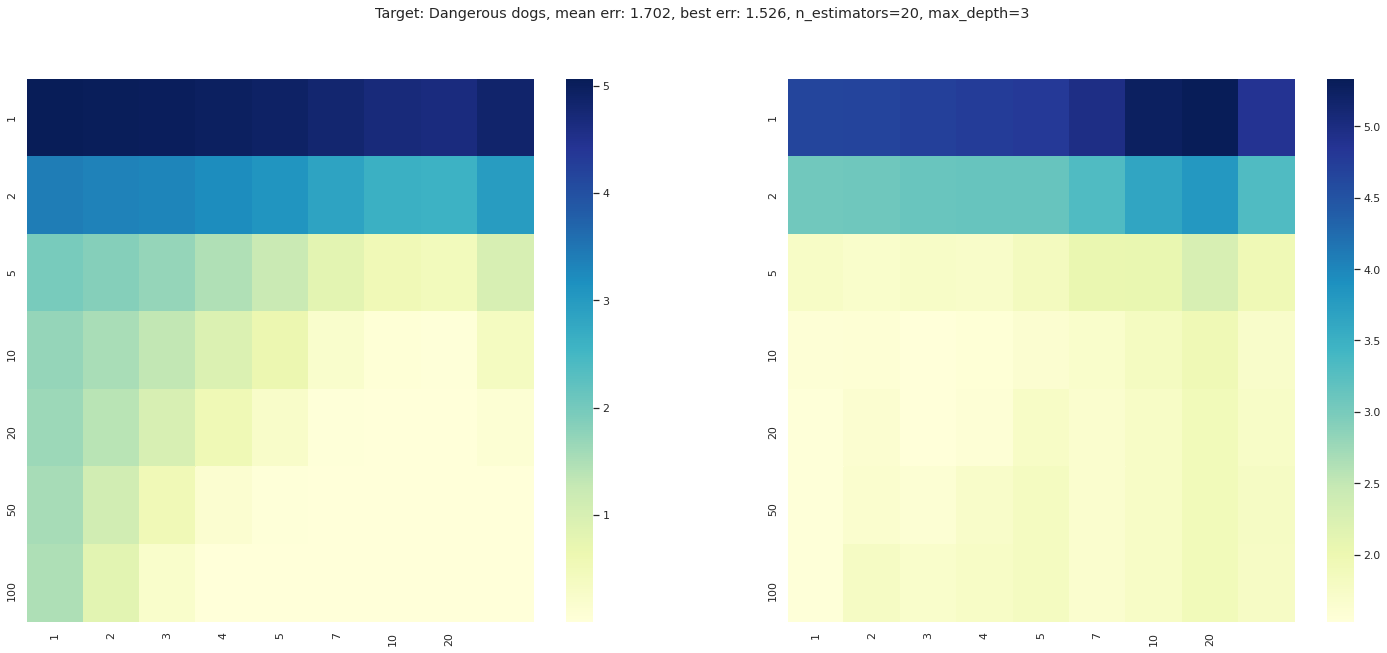

In [175]:
grid_search('Dangerous dogs')

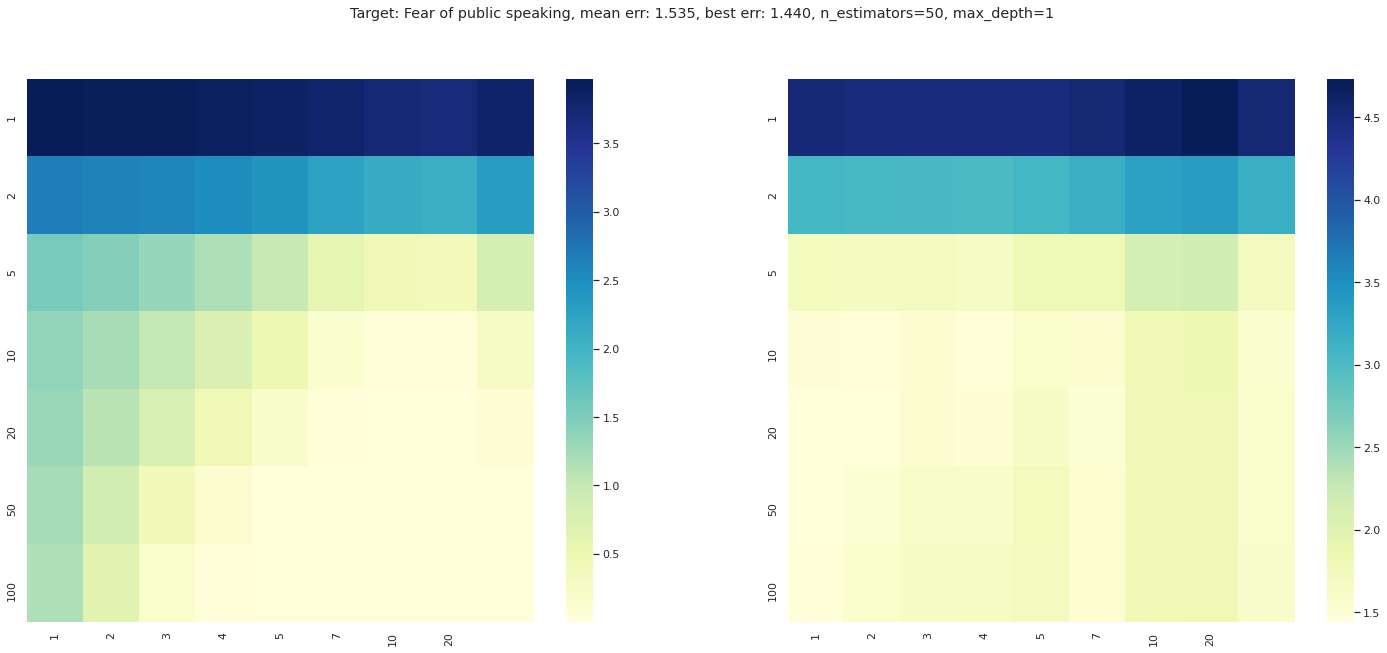

In [176]:
grid_search(phobias_cols[-1])

# Spiders - feature importance

In [15]:
target = "Spiders"
X_train, y_train = train_df[preferences_cols], train_df[target]
X_test, y_test = test_df[preferences_cols], test_df[target]

xg_reg = xgb.XGBRegressor(
    random_state=0,
    n_estimators = 50,
    max_depth = 2,
)

xg_reg.fit(
    X_train,
    y_train,
)

print(f'Target: {target}, mean err: {mean_squared_error(y_test, np.full(len(y_test), y_train.mean())):.3f}, xgb err: {mean_squared_error(y_test, xg_reg.predict(X_test)):.3f}')

Target: Spiders, mean err: 2.427, xgb err: 2.162


In [16]:
feature_inds = np.argsort(-xg_reg.feature_importances_)
for feature, importance in zip(preferences_cols[feature_inds][:20], xg_reg.feature_importances_[feature_inds][:20]):
    print(f'Feature: {feature}, importance: {importance:.3f}')

Feature: Gender, importance: 0.177
Feature: Internet, importance: 0.037
Feature: Romantic, importance: 0.032
Feature: Shopping, importance: 0.029
Feature: Folk, importance: 0.028
Feature: Metal or Hardrock, importance: 0.026
Feature: Economy Management, importance: 0.026
Feature: Pets, importance: 0.023
Feature: Musical instruments, importance: 0.023
Feature: Celebrities, importance: 0.022
Feature: Cars, importance: 0.020
Feature: Western, importance: 0.020
Feature: Classical music, importance: 0.019
Feature: Physics, importance: 0.019
Feature: Reading, importance: 0.019
Feature: Chemistry, importance: 0.017
Feature: Musical, importance: 0.017
Feature: Movies, importance: 0.017
Feature: Comedy, importance: 0.017
Feature: Animated, importance: 0.016


As expected, the gender has high importance in predicting strength of spiders phobia. But the preferences that are corralated with gender (music, movies) also reveal some additional information and are high on the importance list.

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
regr = RandomForestRegressor(max_depth=1, random_state=0, n_estimators=1000)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=1, n_estimators=1000, random_state=0)

In [19]:
print(f'Target: {target}, mean err: {mean_squared_error(y_test, np.full(len(y_test), y_train.mean())):.3f}, xgb err: {mean_squared_error(y_test, regr.predict(X_test)):.3f}')

Target: Spiders, mean err: 2.427, xgb err: 2.110


In [20]:
y_test

801     1.0
311     5.0
85      2.0
435     5.0
204     4.0
       ... 
784     2.0
231     1.0
5       1.0
452     5.0
1009    1.0
Name: Spiders, Length: 202, dtype: float64

In [21]:
estimators = [1,2,5,10,20,50,100,200]
depths = [1,2,3,4,5,7,10,20,None]

In [22]:
rf_train_errors = np.empty((len(estimators), len(depths)))
rf_test_errors = np.empty((len(estimators), len(depths)))

for e, n_estimators in enumerate(estimators):
    for d, max_depth in enumerate(depths):
        X_train, y_train = train_df[preferences_cols], train_df[target]
        X_test, y_test = test_df[preferences_cols], test_df[target]

        rf = RandomForestRegressor(
            random_state=0,
            n_estimators = n_estimators,
            max_depth = max_depth,
        )

        rf.fit(
            X_train,
            y_train,
        )

        rf_train_errors[e, d] = mean_squared_error(y_train, rf.predict(X_train), squared=False)
        rf_test_errors[e, d] = mean_squared_error(y_test, rf.predict(X_test), squared=False)
        
rf_n_estimators = estimators[rf_test_errors.argmin() // len(depths)]
rf_max_depth = depths[rf_test_errors.argmin() % len(depths)]

In [30]:
rf_test_errors.min() 

1.4491692929070572

In [23]:
xgb_train_errors = np.empty((len(estimators), len(depths)))
xgb_test_errors = np.empty((len(estimators), len(depths)))

for e, n_estimators in enumerate(estimators):
    for d, max_depth in enumerate(depths):
        X_train, y_train = train_df[preferences_cols], train_df[target]
        X_test, y_test = test_df[preferences_cols], test_df[target]

        xg_reg = xgb.XGBRegressor(
            random_state=0,
            n_estimators = n_estimators,
            max_depth = max_depth,
        )

        xg_reg.fit(
            X_train,
            y_train,
        )

        xgb_train_errors[e, d] = mean_squared_error(y_train, xg_reg.predict(X_train), squared=False)
        xgb_test_errors[e, d] = mean_squared_error(y_test, xg_reg.predict(X_test), squared=False)

In [ ]:
fig, ax = plt.subplots(2, 2)
sns.heatmap(rf_train_errors, xticklabels=depths, yticklabels=estimators, cmap="YlGnBu", ax=ax[0,0], vmin=0, vmax=2.5)
sns.heatmap(rf_test_errors, xticklabels=depths, yticklabels=estimators, cmap="YlGnBu", ax=ax[0,1], vmin=1, vmax=2.5)
sns.heatmap(xgb_train_errors, xticklabels=depths, yticklabels=estimators, cmap="YlGnBu", ax=ax[1,0], vmin=0, vmax=2.5)
sns.heatmap(xgb_test_errors, xticklabels=depths, yticklabels=estimators, cmap="YlGnBu", ax=ax[1,1], vmin=1, vmax=2.5)
ax[0,0].set_title('Random Forest Train RMSE');ax[0,1].set_title('Random Forest Test RMSE');ax[1,0].set_title('XGBoost Train RMSE');ax[1,1].set_title('XGBoost Test RMSE')
ax[0,0].set_ylabel('number of estimators');ax[0,1].set_ylabel('number of estimators');ax[1,0].set_ylabel('number of estimators');ax[1,1].set_ylabel('number of estimators')
ax[0,0].set_xlabel('max depth');ax[0,1].set_xlabel('max depth');ax[1,0].set_xlabel('max depth');ax[1,1].set_xlabel('max depth')
plt.suptitle('Grid selection of the best regressor in terms of RMSE for predicting Spiders\' phobia')
fig.set_size_inches(16,12)
plt.show()

In [57]:
rf_n_estimators, rf_max_depth

(10, 2)

In [58]:
rf = RandomForestRegressor(
    random_state=0,
    n_estimators = rf_n_estimators,
    max_depth = rf_max_depth,
)

rf.fit(
    X_train,
    y_train,
)

RandomForestRegressor(max_depth=2, n_estimators=10, random_state=0)

In [61]:
feature_inds = np.argsort(-rf.feature_importances_)
for feature, importance in zip(preferences_cols[feature_inds][:20], rf.feature_importances_[feature_inds][:20]):
    print(f'Feature: {feature}, importance: {importance:.3f}')

Feature: Gender, importance: 0.654
Feature: Shopping, importance: 0.102
Feature: Internet, importance: 0.087
Feature: Comedy, importance: 0.028
Feature: Romantic, importance: 0.027
Feature: Slow songs or fast songs, importance: 0.025
Feature: Movies, importance: 0.018
Feature: Techno, Trance, importance: 0.011
Feature: Fantasy/Fairy tales, importance: 0.011
Feature: Passive sport, importance: 0.009
Feature: Dance, importance: 0.008
Feature: Foreign languages, importance: 0.007
Feature: Celebrities, importance: 0.007
Feature: Animated, importance: 0.006
Feature: Geography, importance: 0.000
Feature: Chemistry, importance: 0.000
Feature: Medicine, importance: 0.000
Feature: Biology, importance: 0.000
Feature: Economy Management, importance: 0.000
Feature: Reading, importance: 0.000
